# Overview
Hyperopt is a framework providing numerical methods for optimizing hyperparameters. In this notebook we discuss the supported algorithms and the code to conduct a search. This notebook assumes that the [Intro To Hyperopt Search Spaces notebook](Intro%20To%20Hyperopt%20Search%20Spaces.ipynb) has been read.





# 1. Supported Algorithms
Currently hyperopt uspports the following methods for tuning hyperparameters:

- [Random Search](../../../Data%20Science/Optimization/Optimization.ipynb)
- [Tree of Parzen Estimators (TPE)](../../../Data%20Science/Optimization/Tree-Structured%20Parzen%20Estimator%20%28TPE%29.ipynb)

Note: The hyperopt documentation claims to support the Adaptive TPE algorithm but it seems (based on an [open issue](https://github.com/hyperopt/hyperopt/issues/828)) that the ATPE algorithm is implimented as part of anotherlibrariy called [hypermax](https://github.com/electricbrainio/hypermax).

# 2. Conducting a search
We saw some examples of defining search spaces and conducting searches in the [search space notebook](Hyperopt%20Search%20Space.ipynb).

In the examples below we will look at the comparison between the algorithms.

## 2.1. Define Search space

For this contrived demonstration I will be searching a space which I already know the best answer for. In our case we will use a bi-dimensional space. In orhter words we will have a function that takes an $x$ and $y$ variable.

We know that the point $f(x=0, y=0)$ should yield the optimal value given that it is the center of the standard normal random variable we see above.

As such, I will define the search space as a grid of 5000 by 5000 points representing x and y.

In [28]:
import hyperopt
import numpy

# Define the search space
space = hyperopt.hp.choice('my_choice', [
    {
        'name': 'model a',
        'x': hyperopt.hp.choice('model_a_x', numpy.linspace(-10,10,500)),
        'y': hyperopt.hp.choice('model_a_y', numpy.linspace(-10,10,500))
    },
    {
        'name': 'model b',
        'x': hyperopt.hp.choice('model_b_x', numpy.linspace(-10,10,500)),
        'y': hyperopt.hp.choice('model_b_y', numpy.linspace(-10,10,500))
    }
])

## 2.2. Define Objective Function
I next define the objective function. The objective function will be the probability density function for the normal distribution. 

$$ f \sim \mathcal{N}(0,5) $$

I am using this function because its a nice curve for demonstrating our purposes, we know that it has one maxima, and we know what that maxima is.

Below is a visualization of this objective function over the search space:

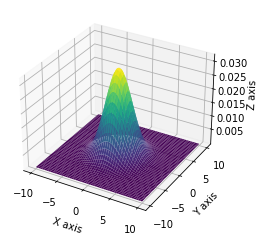

In [18]:
import numpy
from  matplotlib import pyplot
import scipy.stats
from mpl_toolkits import mplot3d

# Create a normal random variable
μ = [0, 0]
Σ = [[5,   0], 
     [0,   5]]
rv = scipy.stats.multivariate_normal(μ, Σ)

# Create a set of points for the x and y axis
x = numpy.linspace(-10,10,500)
y = numpy.linspace(-10,10,500)

# Generate a mesh grid
X, Y = numpy.meshgrid(x,y)

# Pack X and Y into a single 3-dimensional array
pos = numpy.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

#Make a 3D plot
fig = pyplot.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
pyplot.show()

And thus the optimal value for the (0,0) point is

In [53]:
rv.pdf([0,0])

0.03183098861837907

Recall that hyperopt finds the minimal point, not the maximal point. As such we will augment our objective function to handle this by retuning a value 
$$f^* = -f^2$$

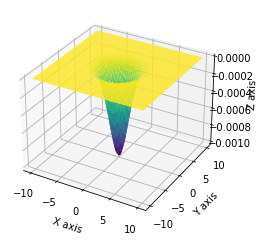

In [47]:
import numpy
from  matplotlib import pyplot
import scipy.stats
from mpl_toolkits import mplot3d

# Create a normal random variable
μ = [0, 0]
Σ = [[5,   0], 
     [0,   5]]
rv = scipy.stats.multivariate_normal(μ, Σ)

# Create a set of points for the x and y axis
x = numpy.linspace(-10,10,500)
y = numpy.linspace(-10,10,500)

# Generate a mesh grid
X, Y = numpy.meshgrid(x,y)

# Pack X and Y into a single 3-dimensional array
pos = numpy.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

#Make a 3D plot
fig = pyplot.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, -(rv.pdf(pos)**2),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
pyplot.show()

And thus the optimal value for the (0,0) point is

In [55]:
-(rv.pdf([0,0])**2)

-0.0010132118364233778

For the sake of the demonstartion, I will also modify the objective function so that model a performs slightly better than model b by adding a small penalty.

We define the loss function:

In [52]:
# Create a normal random variable so we can use it's pmf function
μ = [0, 0]
Σ = [[5,   0], 
     [0,   5]]
rv = scipy.stats.multivariate_normal(μ, Σ)

# Define the objective function
def objective(args):
    x = args['x']
    y = args['y']
    p = rv.pdf([x, y])
    f = -(p**2)
    
    model = args['name']
    if model == 'model b':
        f = f + 0.01
        
    return f

## 2.3. Search
### 2.3.1. Search Using Random Search Algorithm

In [65]:
# Define an object to keep track of the "trials" in the search path
trials = hyperopt.Trials()
    
# Optimize the search space and retrieve the index which points to the best points in the search space
optimal_args_index = hyperopt.fmin(objective, space, algo=hyperopt.rand.suggest, max_evals=1000, trials=trials, rstate= numpy.random.RandomState(42), loss_threshold=-0.001)
    
# Retrieve the resulting hyperparameter set from the search space using the index
optimal_hyperparams = hyperopt.space_eval(space, optimal_args_index)

# Print the results
print("=========================")
print("Optimal args index:")
print(optimal_args_index)
print("Best hyperparameters:")
print(optimal_hyperparams)
print("Objective function score:")
print(objective(optimal_hyperparams))

100%|█| 1000/1000 [00:29<00:00, 34.21trial/s, best loss: -0.0009892478960327486
Optimal args index:
{'model_a_x': 258, 'model_a_y': 251, 'my_choice': 0}
Best hyperparameters:
{'name': 'model a', 'x': 0.3406813627254497, 'y': 0.060120240480960874}
Objective function score:
-0.0009892478960327486


### 2.3.2. Search Using TPE Algorithm

In [66]:
# Define an object to keep track of the "trials" in the search path
trials = hyperopt.Trials()
    
# Optimize the search space and retrieve the index which points to the best points in the search space
optimal_args_index = hyperopt.fmin(objective, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials, rstate= numpy.random.RandomState(42), loss_threshold=-0.001)
    
# Retrieve the resulting hyperparameter set from the search space using the index
optimal_hyperparams = hyperopt.space_eval(space, optimal_args_index)

# Print the results
print("=========================")
print("Optimal args index:")
print(optimal_args_index)
print("Best hyperparameters:")
print(optimal_hyperparams)

 56%|█ | 558/1000 [01:55<01:31,  4.83trial/s, best loss: -0.001004621947665017]
Optimal args index:
{'model_a_x': 252, 'model_a_y': 245, 'my_choice': 0}
Best hyperparameters:
{'name': 'model a', 'x': 0.10020040080160264, 'y': -0.18036072144288617}


### 2.3.3. Compare Results
There are a few interesting results to be observed:

- We started with a search space that spanned $500 * 500 = 250,000$ grid coordinates. We told each search algorithm to stop after 1000 iterations which is roughtly 0.4% of the search space.

- We can see that TPE was not as fast as random search. In fact it is almost 6 times slower having clocked around 5 trial/s while random search was closer to 30 trial/s. This also means that TPE ran longer while achieving less trials (it ran for 2 minutes compared to 30 seconds) This is because TPE is more complex as it's not pulling numbers out of a hat. As such, random search will cover more ground than TPE given the same window of time. That being said, it is no guarantee random search will find a better answer more quickly as we see below.

- We can see that TPE will likely converge in less iterations than random search. While random search excaused the maximum number of trials, TPE used about half the required trials. Thus TPE is more inteligent in the way it serches.

- We also see that TPE was able to find a better result than random search given the criteria. I was curious to see how many iterations/how long for random search to find a comparable solution (given the same threshold) so I ran one last trial below:

In [70]:
# Define an object to keep track of the "trials" in the search path
trials = hyperopt.Trials()
    
# Optimize the search space and retrieve the index which points to the best points in the search space
optimal_args_index = hyperopt.fmin(objective, space, algo=hyperopt.rand.suggest, max_evals=500*500, trials=trials, rstate= numpy.random.RandomState(42), loss_threshold=-0.001)
    
# Retrieve the resulting hyperparameter set from the search space using the index
optimal_hyperparams = hyperopt.space_eval(space, optimal_args_index)

# Print the results
print("=========================")
print("Optimal args index:")
print(optimal_args_index)
print("Best hyperparameters:")
print(optimal_hyperparams)
print("Objective function score:")
print(objective(optimal_hyperparams))

  2%| | 5104/250000 [03:15<2:36:25, 26.09trial/s, best loss: -0.001009150888862
Optimal args index:
{'model_a_x': 252, 'model_a_y': 252, 'my_choice': 0}
Best hyperparameters:
{'name': 'model a', 'x': 0.10020040080160264, 'y': 0.10020040080160264}
Objective function score:
-0.0010091508888626715


And so we see, it takes random search an extra minute to find a point comparable to the one found by TPE.